In [2]:
from location import Location
port_location = Location(name='Tweede Maasvlakte, Netherlands', tiles=None, examples=[(1, 5), (2, 6), (4, 10)], meters_per_pixel=0.5)
port_location.load()

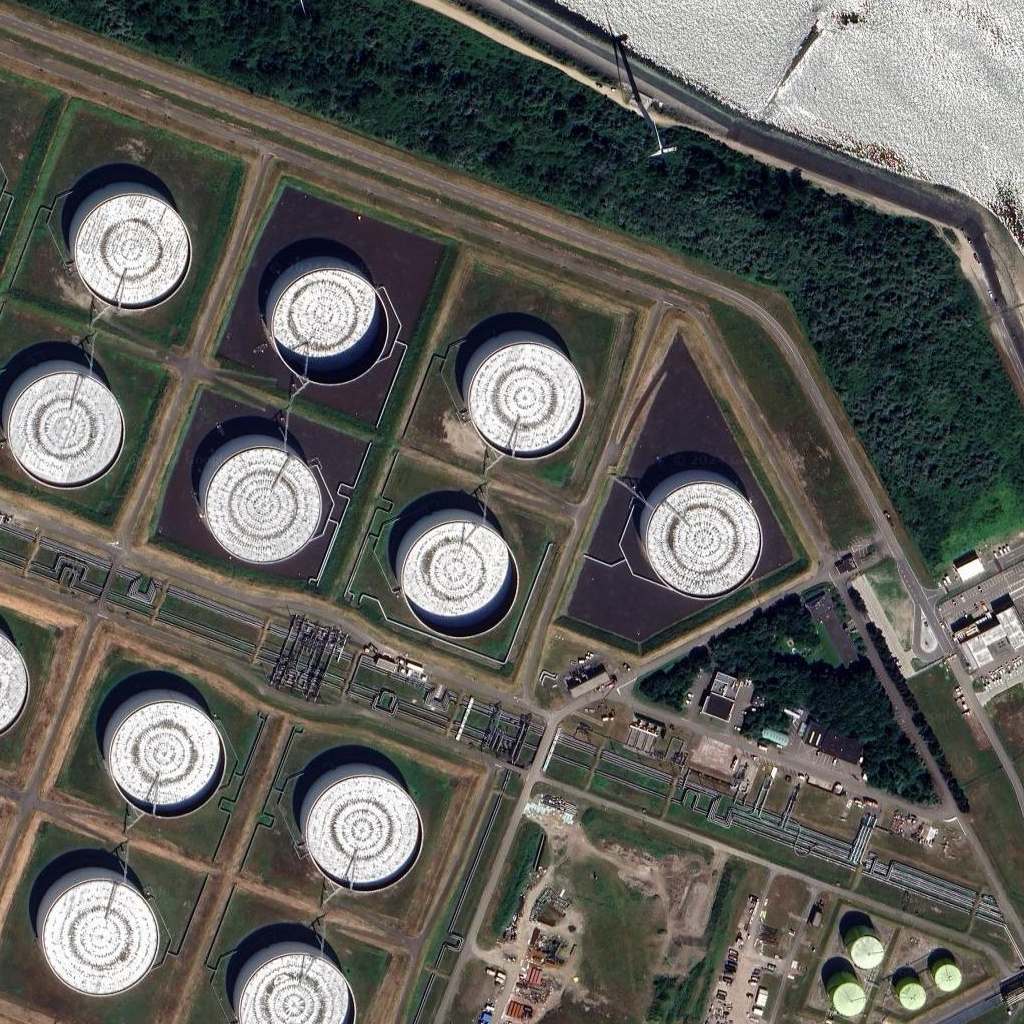

In [3]:
port_location.tiles[(1, 5)]

In [4]:
from PIL import Image
import io
import base64

def pil_to_base64(image, format="PNG"):
    """
    Convert a PIL image to a Base64-encoded string.

    Args:
        image (PIL.Image.Image): The PIL image to convert.
        format (str): The format to save the image (e.g., "PNG", "JPEG").

    Returns:
        str: Base64-encoded image string.
    """
    # Create a bytes buffer
    buffer = io.BytesIO()
    
    # Save the image to the buffer in the specified format
    image.save(buffer, format=format)
    
    # Get the byte data from the buffer
    buffer.seek(0)
    image_bytes = buffer.read()
    
    # Encode the byte data to Base64
    base64_image = base64.b64encode(image_bytes).decode("utf-8")
    
    return base64_image


In [5]:

css_style = """
.container {
    display: flex;
    flex-direction: column;
    align-items: center;
    margin: 20px auto;
}
.row {
    display: flex;
    flex-direction: row;
    align-items: center;
    width: 80%;
    margin-bottom: 10px;
    border: 1px solid #ccc;
    padding: 10px;
    border-radius: 5px;
    box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.1);
}
.index {
    flex: 1;
    text-align: center;
    font-weight: bold;
    color: #333;
}
.image {
    flex: 3;
    text-align: center;
}
img {
    max-width: 100%;
    height: auto;
    border-radius: 5px;
}
"""

In [6]:
from time import sleep
ex_prompt1 = "Count ships!"
ex_prompt2 = "Count ships! Show how you did it."

def process_individually(prompt: str, images: list[Image.Image], pixels_per_meter:float, threshold:float = .5) -> list:
    # sleep for 3 seconds to avoid rate limit
    sleep(.5)
    if prompt == ex_prompt1:
        return [(f"On this image I see {i} ships: ", img, None) for i, img in enumerate(images, 1)]

    elif prompt == ex_prompt2:
        return [(f"On this image I see {i} ships: ", img, img) for i, img in enumerate(images, 1)]
    else:
        raise ValueError(f"Unknown prompt: {prompt}")

def process_examples(prompt, location):
    example_images = [location.tiles[example] for example in location.examples]
    return process_individually(prompt, example_images, port_location.meters_per_pixel)
process_examples(ex_prompt1, port_location)

[('On this image I see 1 ships: ',
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
  None),
 ('On this image I see 2 ships: ',
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
  None),
 ('On this image I see 3 ships: ',
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
  None)]

In [19]:
def process_individual(prompt, image):
    if prompt != ex_prompt1 and prompt != ex_prompt2:
        raise ValueError(f"Unknown prompt: {prompt}")
    sleep(.02)
    return 3


In [32]:

import os
from pathlib import Path

import base64
import gradio as gr

# Specify your folder containing the images
image_folder = "img/"

locations_dict = {
    "Netherlands port": port_location,
    "New York ": None,
    "Sahara": None,
}


# Load image file paths
image_paths = sorted(Path(image_folder).glob("*.png")) + sorted(Path(image_folder).glob("*.jpg"))
image_data = [(index, str(path)) for index, path in enumerate(image_paths)]

# CSS to style the layout

# Function to generate HTML content for images
def display_images(prompt_input: str, location_name: str):
    location = locations_dict[location_name]
    api_response = process_examples(prompt_input, location)
    
    assert len(api_response[0]) == 3

    html_content = '<div class="container">'
    for answer, example_image, annotated_image in api_response:
        #with open(image_path, "rb") as img_file:
        #    base64_image = base64.b64encode(img_file.read()).decode("utf-8")
        base64_image = pil_to_base64(example_image)    
        html_content += f"""
        <div class="row">
            <div class="image"><img src="data:image/png;base64,{base64_image}"></div>
            {
                "" if annotated_image is None else f'<div class="image"><img src="data:image/png;base64,{base64_image}"></div>'
            }

            <div class="index">{answer}</div>
        </div>
        """
    html_content += "</div>"
    return html_content

def submit_all(prompt_input: str, location_name: str, progress=gr.Progress()):
    progress(0, desc="Starting")
    sleep(1)
    progress(0.05)

    final_output.visible = True
    location = locations_dict[location_name]

    for tile in progress.tqdm(location.tiles.values(), desc="Reversing"):
        process_individual(prompt_input, tile)

    return gr.Text('Yes', visible=True)


# Create the Gradio app
with gr.Blocks(css=css_style) as demo:
    with gr.Row():
        with gr.Column(scale=1):
            prompt_input = gr.Text(ex_prompt2, label="Prompt")
            submit_button = gr.Button("Submit")
        
            
        with gr.Column(scale=1):
            location_selection = gr.Dropdown(
                choices=list(locations_dict.keys()),
                label="Select an Image",
                interactive=True
            )
            #image_display = gr.Image(label="Selected Image", interactive=False) TODO!

            # dropdown.change(display_image, inputs=, outputs=image_display)
    gr.Markdown("# Image Viewer")
    gr.Markdown("Click the button below to load images.")
    
    # Add an empty HTML element
    output = gr.HTML(value="")

    # Add a button to load images
    

    # Update the HTML content when the button is pressed
    submit_button.click(display_images, inputs=[prompt_input, location_selection], outputs=output)

    run_button = gr.Button("Run")
    final_output = gr.Text("")
    run_button.click(submit_all, inputs=[prompt_input, location_selection], outputs=final_output)

# Run the app
demo.launch()


* Running on local URL:  http://127.0.0.1:7880

To create a public link, set `share=True` in `launch()`.
